# Toxicity signal analysis


In [156]:
from datasets import load_dataset
import cohere
import numpy as np
import os

EMBEDDING_MODEL = 'large'
BATCH_SIZE = 96
TEMPLATE = '{}'
co = cohere.Client(os.environ['COHERE_API_KEY'])

train_data = load_dataset('jigsaw_toxicity_pred',
                          data_dir='../datasets/jigsaw_toxicity_pred',
                          split='train[:30%]')
test_data = load_dataset('jigsaw_toxicity_pred',
                         data_dir='../datasets/jigsaw_toxicity_pred',
                         split='test[:20%]')


In [157]:
from sklearn.preprocessing import normalize


def compute_embedding(texts: list[str]) -> np.ndarray:
  """Compute cohere embeddings for a list of texts."""
  texts = [TEMPLATE.replace('{}', text) for text in texts]
  cohere_embeddings = co.embed(texts, truncate='START', model=EMBEDDING_MODEL).embeddings
  return np.array(cohere_embeddings)


def get_embeddings(dataset) -> np.ndarray:
  fname = f'{dataset.builder_name}_{dataset.split}_{EMBEDDING_MODEL}_embeddings.npy'
  try:
    embeddings = np.load(fname)
  except FileNotFoundError:
    data = dataset.map(lambda batch: {'x': compute_embedding(batch['comment_text'])},
                       batched=True,
                       batch_size=BATCH_SIZE)
    embeddings = np.array(data['x'])
    np.save(fname, embeddings)

  embeddings = normalize(embeddings).astype(np.float16)
  return embeddings

### Compute the embeddings


In [76]:
def _make_balanced_data(data, embeddings, sample_size_per_group):
  df = data.to_pandas()
  groups = df['toxic'].groupby(df['toxic']).groups
  positive_examples = groups[1][:sample_size_per_group]
  negative_examples = groups[0][:sample_size_per_group]
  positive_embeddings = embeddings[positive_examples]
  negative_embeddings = embeddings[negative_examples]
  positive_labels = np.ones(len(positive_embeddings))
  negative_labels = np.zeros(len(negative_embeddings))
  positive_text = df.loc[positive_examples]['comment_text']
  negative_text = df.loc[negative_examples]['comment_text']
  embeddings = np.concatenate([positive_embeddings, negative_embeddings])
  labels = np.concatenate([positive_labels, negative_labels])
  text = np.concatenate([positive_text, negative_text])
  return embeddings, labels, text

In [198]:
from sklearn.linear_model import LogisticRegression

train_embeddings = get_embeddings(train_data)
test_embeddings = get_embeddings(test_data)

model = LogisticRegression(class_weight='balanced', C=30, warm_start=True, max_iter=1_000)

## Train a model


In [199]:
from sklearn.metrics import roc_auc_score

from src.utils import DebugTimer

SAMPLE_SIZE_PER_GROUP = 512
embeddings, labels, texts = _make_balanced_data(train_data, train_embeddings, SAMPLE_SIZE_PER_GROUP)
with DebugTimer('Training a model'):
  model.fit(embeddings, labels)

roc_auc = roc_auc_score(labels, model.predict_proba(embeddings)[:, 1])
print(f'ROC AUC on train set, {len(embeddings)} examples: {roc_auc:.3f}')

test_labels = np.array(test_data['toxic'])
roc_auc = roc_auc_score(test_labels, model.predict_proba(test_embeddings)[:, 1])
print(f'ROC AUC on test set, {len(test_labels)} examples: {roc_auc:.3f}')
accuracy = model.score(test_embeddings, test_labels)
print(f'Accuracy on test set, {len(test_labels)} examples: {accuracy:.3f}')

Training a model took 0.295s.
ROC AUC on train set, 1024 examples: 1.000
ROC AUC on test set, 12796 examples: 0.935
Accuracy on test set, 12796 examples: 0.864


## Save the concept


In [202]:
from src.concepts.concept import Concept, Example

data = {}

for index, (label, text) in enumerate(zip(labels, texts)):
  id = str(index)
  ex = Example(label=bool(label), text=text, id=str(index))
  data[id] = ex

concept = Concept(namespace='local', concept_name='toxicity', type='text', data=data)

with open('gcs_cache/concept/local/toxicity/concept.json', 'w') as f:
  f.write(concept.json(exclude_none=True, exclude_unset=True, indent=2))

(array([353.,  52.,  48.,  23.,  10.,  13.,   4.,   5.,   3.,   0.,   2.,
          3.,   5.,   5.,  12.,  10.,  27.,  39.,  66., 344.]),
 array([2.85130841e-05, 5.00268831e-02, 1.00025253e-01, 1.50023623e-01,
        2.00021993e-01, 2.50020363e-01, 3.00018733e-01, 3.50017103e-01,
        4.00015473e-01, 4.50013843e-01, 5.00012213e-01, 5.50010583e-01,
        6.00008953e-01, 6.50007323e-01, 7.00005693e-01, 7.50004063e-01,
        8.00002433e-01, 8.50000803e-01, 8.99999173e-01, 9.49997543e-01,
        9.99995913e-01]),
 <BarContainer object of 20 artists>)

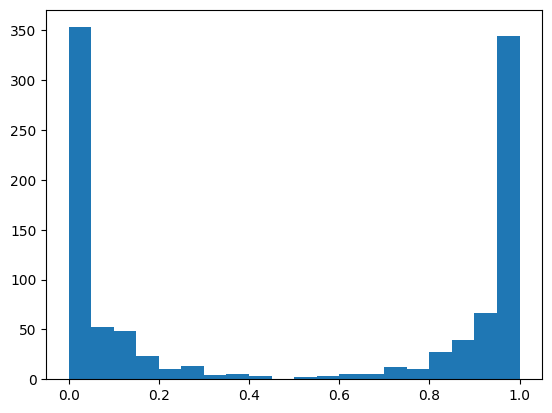

In [200]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.hist(model.predict_proba(embeddings)[:, 1], bins=20)

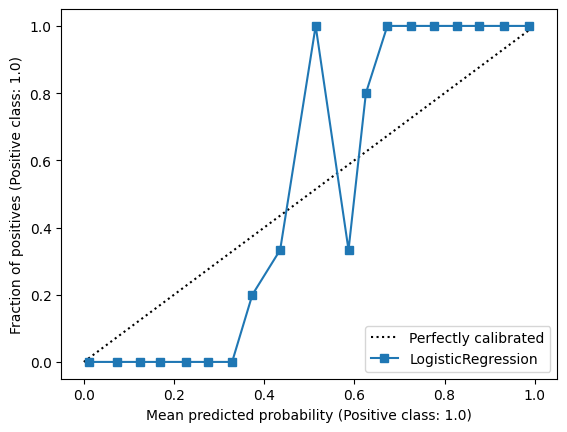

In [201]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

CalibrationDisplay.from_estimator(model, embeddings, labels, n_bins=20)
plt.show()